In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime
from datetime import date
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler, normalize
from sklearn import metrics
from sklearn.mixture import GaussianMixture
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import warnings
warnings.filterwarnings('ignore')
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/customer-personality-analysis/marketing_campaign.csv


In [2]:
%config Completer.use_jedi = False #AutoCompletion

In [3]:
data = pd.read_csv("/kaggle/input/customer-personality-analysis/marketing_campaign.csv", sep='\t')
data.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [4]:
print(len(data.columns))
data.columns

29


Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response'],
      dtype='object')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [6]:
data['Dt_Customer'] =pd.to_datetime(data['Dt_Customer'])

In [7]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,2240.0,5592.159821,3246.662198,0.0,2828.25,5458.5,8427.75,11191.0
Year_Birth,2240.0,1968.805804,11.984069,1893.0,1959.00,1970.0,1977.00,1996.0
Income,2216.0,52247.251354,25173.076661,1730.0,35303.00,51381.5,68522.00,666666.0
Kidhome,2240.0,0.444196,0.538398,0.0,0.00,0.0,1.00,2.0
Teenhome,2240.0,0.506250,0.544538,0.0,0.00,0.0,1.00,2.0
Recency,2240.0,49.109375,28.962453,0.0,24.00,49.0,74.00,99.0
MntWines,2240.0,303.935714,336.597393,0.0,23.75,173.5,504.25,1493.0
MntFruits,2240.0,26.302232,39.773434,0.0,1.00,8.0,33.00,199.0
MntMeatProducts,2240.0,166.950000,225.715373,0.0,16.00,67.0,232.00,1725.0
MntFishProducts,2240.0,37.525446,54.628979,0.0,3.00,12.0,50.00,259.0


* Income Column contains 24 null valued rows, we can remove these rows
* KidHome and TeenHome could be combined
* Z_CostContact and Z_revenue column doesn't contains any variability, hence we can remove these cols. 
* Age feature can be added by calculating difference between Year- YearBirth

In [8]:
print(data.shape)
print("After performing some transformations")
tran_data= data.copy()
tran_data = tran_data[tran_data['Income'].notnull()]

tran_data['Year'] = tran_data['Dt_Customer'].apply(lambda row:row.year)


tran_data['Children'] = tran_data['Kidhome']+ tran_data['Teenhome']
tran_data['Age'] = pd.Timestamp('now').year- tran_data['Year_Birth']

tran_data = tran_data.drop(['ID','Z_CostContact', 'Z_Revenue', 'Kidhome', 'Teenhome', 'Dt_Customer', 'Year', 'Year_Birth'], axis=1)

print(tran_data.shape)

(2240, 29)
After performing some transformations
(2216, 24)


In [9]:
tran_data['Education'].value_counts()

Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: Education, dtype: int64

In [10]:
#regrouping EDucaation as Fully Graduated and under_graduated
tran_data.Education = tran_data.Education.replace(['PhD','Graduation', 'Master'], 'fully_Graduated')

tran_data.Education = tran_data.Education.replace(['Basic', '2n Cycle'], 'under_Graduated')
tran_data['Education'].value_counts()

fully_Graduated    1962
under_Graduated     254
Name: Education, dtype: int64

In [11]:
tran_data['Marital_Status'].value_counts()

Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: Marital_Status, dtype: int64

In [12]:
tran_data.Marital_Status = tran_data.Marital_Status.replace(['Married','Together'], 'Partner')

tran_data.Marital_Status = tran_data.Marital_Status.replace(['Single','Divorced', 'Widow', 'Alone','Absurd', 'YOLO'], 'Single')
tran_data['Marital_Status'].value_counts()

Partner    1430
Single      786
Name: Marital_Status, dtype: int64

<AxesSubplot:xlabel='Income'>

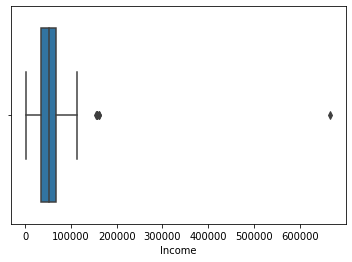

In [13]:
sns.boxplot(tran_data['Income'])


In [14]:
#removing Income >200000
tran_data=tran_data[tran_data['Income']<200000]
tran_data.shape

(2215, 24)

In [15]:
#Calling all the amount on commmodities as expense
cols = [i for i in tran_data.columns if str(i).startswith('Mnt')]
print(cols)
tran_data['Expense'] = tran_data[['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']].sum(axis=1)
tran_data=tran_data.drop(cols, axis=1)
tran_data['Expense']

['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']


0       1617
1         27
2        776
3         53
4        422
        ... 
2235    1341
2236     444
2237    1241
2238     843
2239     172
Name: Expense, Length: 2215, dtype: int64

In [16]:
#response to campaign in column
xgb_data = tran_data.copy()
cols_response= [i for i in tran_data.columns if str(i).startswith('Accept')]
cols_response= cols_response +['Response']
tran_data['Responses'] = tran_data[cols_response].sum(axis = 1)

# if there is any responses it would be 1 otherwise it would be 0
def mapp(num):
    if num >=1:
        result = 1
    else:
        result = 0
    return result


tran_data['Responses'] = tran_data['Responses'].apply(mapp)
tran_data= tran_data.drop(cols_response, axis=1)
tran_data['Responses'].value_counts()

0    1610
1     605
Name: Responses, dtype: int64

In [17]:
tran_data.head().T

,0,1,2,3,4
Education,fully_Graduated,fully_Graduated,fully_Graduated,fully_Graduated,fully_Graduated
Marital_Status,Single,Single,Partner,Partner,Partner
Income,58138.0,46344.0,71613.0,26646.0,58293.0
Recency,58,38,26,26,94
NumDealsPurchases,3,2,1,2,5
NumWebPurchases,8,1,8,2,5
NumCatalogPurchases,10,1,2,0,3
NumStorePurchases,4,2,10,4,6
NumWebVisitsMonth,7,5,4,6,5
Complain,0,0,0,0,0


In [18]:
# Replacing the age with the age groups

def age_category(age):
    if  25<=age <= 35:
        age = 0
    elif 35 < age <= 45:
        age = 1
    elif 45 < age <= 55:
        age = 2
    elif 55 < age <= 65:
        age = 3
    elif 65 < age <= 75:
        age = 4
    elif age > 75:  
        age = 5
    return age  

tran_data.Age = tran_data.Age.apply(age_category)
tran_data.Age.unique()

xgb_data.Age = xgb_data.Age.apply(age_category)
xgb_data.Age.unique()

array([3, 4, 1, 2, 0, 5])

In [19]:
#Dropping unwanted Columns 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth'
drop_cols= ['NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']
tran_data.drop(drop_cols, axis = 1,inplace = True)
xgb_data.drop(drop_cols, axis = 1,inplace = True)

In [20]:
#scaling numerical and categorical data
cat_cols= tran_data.select_dtypes('object').columns 
print(cat_cols)
tran_data =pd.get_dummies(columns=cat_cols,data=tran_data)
xgb_data =pd.get_dummies(columns=cat_cols,data=xgb_data)



Index(['Education', 'Marital_Status'], dtype='object')


<AxesSubplot:>

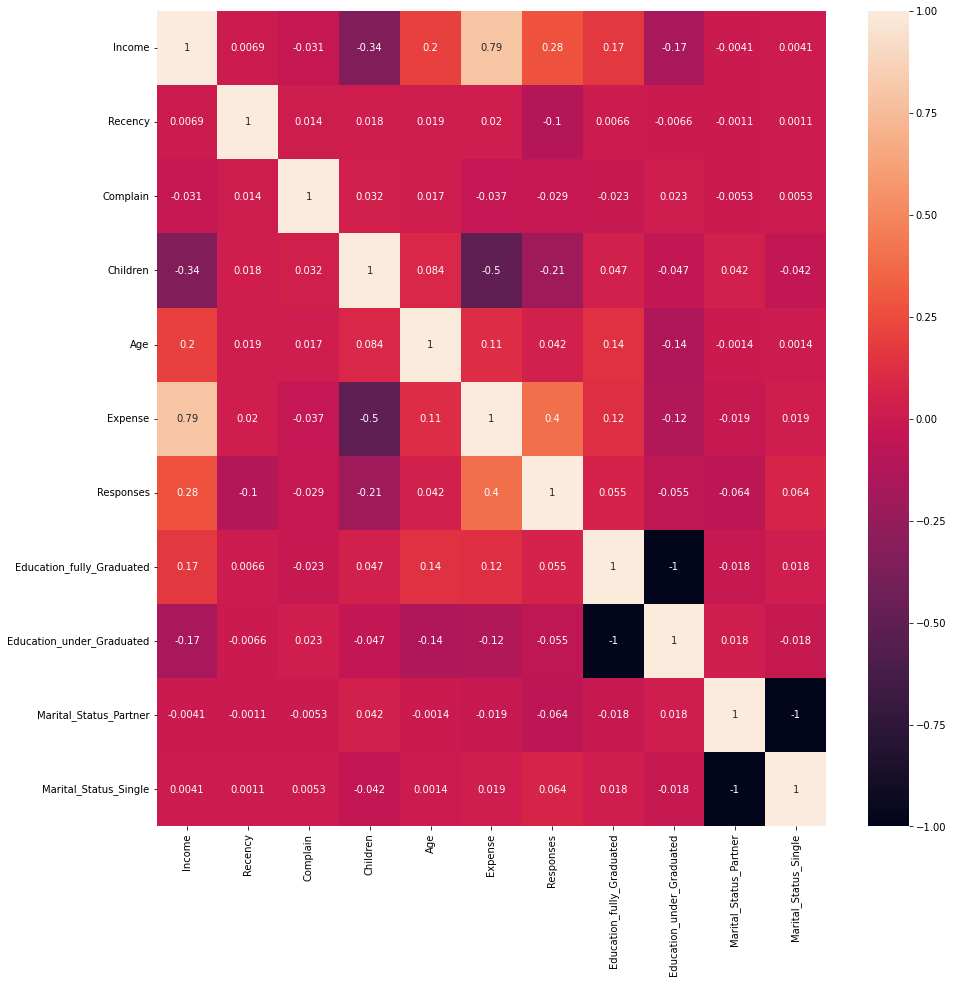

In [21]:
plt.figure(figsize= (15,15))
sns.heatmap(tran_data.corr(), annot=True)

Looking into the heat map it is clear that Columns with the nature of expences purchases a higher correlation with the income

In [22]:
tran_data.nunique()

Income                       1973
Recency                       100
Complain                        2
Children                        4
Age                             6
Expense                      1047
Responses                       2
Education_fully_Graduated       2
Education_under_Graduated       2
Marital_Status_Partner          2
Marital_Status_Single           2
dtype: int64

In [23]:
from sklearn.preprocessing import StandardScaler
to_scale= ['Income', 'Recency', 'Expense']
X_Scaled =StandardScaler().fit_transform(tran_data[to_scale])
X_Scaled[:5,:]

array([[ 0.28660409,  0.31011292,  1.67501109],
       [-0.26140705, -0.38089872, -0.96272705],
       [ 0.91272331, -0.79550571,  0.2798301 ],
       [-1.17667951, -0.79550571, -0.91959423],
       [ 0.29380621,  1.55393388, -0.3074399 ]])

In [24]:
X_Scaled =pd.DataFrame(X_Scaled, columns =to_scale)
final_data = pd.concat((tran_data.drop(to_scale, axis=1), X_Scaled), axis=1)
final_data.head()


,Complain,Children,Age,Responses,Education_fully_Graduated,Education_under_Graduated,Marital_Status_Partner,Marital_Status_Single,Income,Recency,Expense
0,0.0,0.0,3.0,1.0,1.0,0.0,0.0,1.0,0.286604,0.310113,1.675011
1,0.0,2.0,4.0,0.0,1.0,0.0,0.0,1.0,-0.261407,-0.380899,-0.962727
2,0.0,0.0,3.0,0.0,1.0,0.0,1.0,0.0,0.912723,-0.795506,0.279830
3,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,-1.176680,-0.795506,-0.919594
4,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.293806,1.553934,-0.307440


In [25]:
tran_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2215 entries, 0 to 2239
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Income                     2215 non-null   float64
 1   Recency                    2215 non-null   int64  
 2   Complain                   2215 non-null   int64  
 3   Children                   2215 non-null   int64  
 4   Age                        2215 non-null   int64  
 5   Expense                    2215 non-null   int64  
 6   Responses                  2215 non-null   int64  
 7   Education_fully_Graduated  2215 non-null   uint8  
 8   Education_under_Graduated  2215 non-null   uint8  
 9   Marital_Status_Partner     2215 non-null   uint8  
 10  Marital_Status_Single      2215 non-null   uint8  
dtypes: float64(1), int64(6), uint8(4)
memory usage: 211.6 KB


In [26]:
final_data.dropna(inplace=True)

# Build unsupervised Algorithm to cluster customer data

In [27]:
features = ['Income', 'Age', 'Expense']

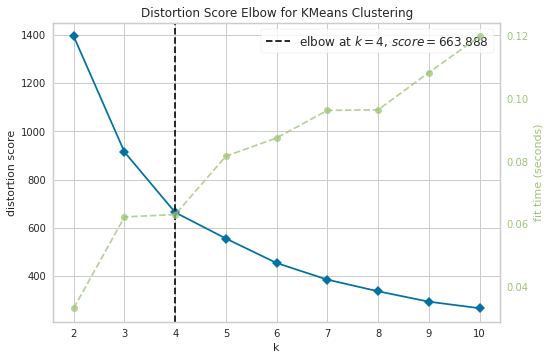

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [28]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

model = KMeans(init = 'k-means++')
visualizer = KElbowVisualizer(model, k = 10, random_state = 42)

visualizer.fit(final_data[['Income',  'Expense']])
visualizer.show()

In [29]:
model = KMeans(n_clusters=4, init='k-means++', random_state=42).fit(final_data[['Income', 'Expense']])
preds = model.predict(final_data[['Income', 'Expense']])
dt_Kmeans = final_data[['Income','Expense']]
dt_Kmeans['Cluster'] = preds

The number of optimum clusters are 4.

Text(0.5, 1.0, 'PLot Showing Income distribution for different clusters')

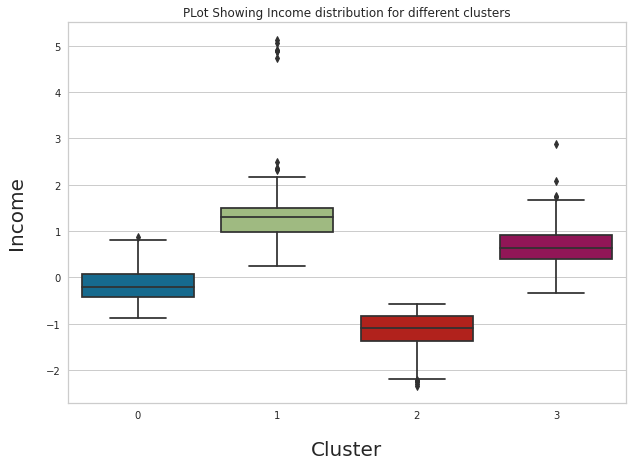

In [30]:
plt.figure(figsize=(10,7))
sns.boxplot(data=dt_Kmeans, x='Cluster', y = 'Income');
plt.xlabel('Cluster', fontsize=20, labelpad=20)
plt.ylabel('Income', fontsize=20, labelpad=20)
plt.title("PLot Showing Income distribution for different clusters")

Text(0.5, 1.0, 'PLot Showing Expense distribution for different clusters')

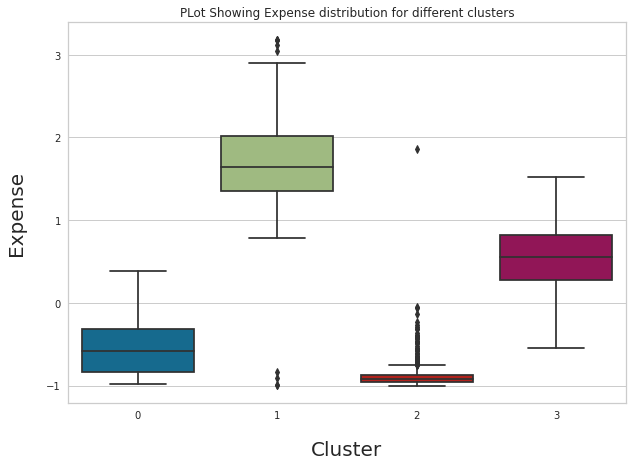

In [31]:
plt.figure(figsize=(10,7))
sns.boxplot(data=dt_Kmeans, x='Cluster', y = 'Expense');
plt.xlabel('Cluster', fontsize=20, labelpad=20)
plt.ylabel('Expense', fontsize=20, labelpad=20)
plt.title("PLot Showing Expense distribution for different clusters")

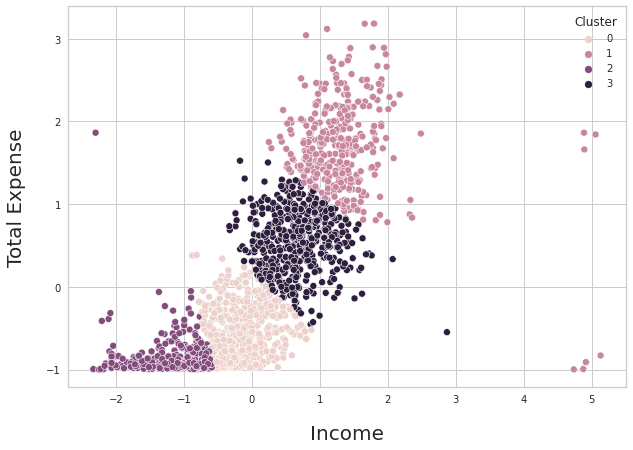

In [32]:
plt.figure(figsize=(10,7))
sns.scatterplot(data=dt_Kmeans, x='Income', y='Expense', hue='Cluster');
plt.xlabel('Income', fontsize=20, labelpad=20)
plt.ylabel('Total Expense', fontsize=20, labelpad=20);

In the above plot we have developed multiple cluster mostly based on the income and Expense of the customer , like high income and high Expense customer , high income and low spending customer , low income low spending customer and a very few points of customers
who are low income and high spending customers .
This gives us various segments of Customers based on their income and Spending.

# 2 Build a classification model (binomial or multinomial - recommended: xgboost python implementation) on the promotion done by the company.

Build a classification model (binomial or multinomial - recommended: xgboost python implementation) on the promotion done by the company. Run SHAP analysis on the model results, and write a short text of what would be your recommendation to business for the next round of campaigns.

In [33]:
import xgboost as xgb

In [34]:
xgb_data.head()

,Income,Recency,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Children,Age,Expense,Education_fully_Graduated,Education_under_Graduated,Marital_Status_Partner,Marital_Status_Single
0,58138.0,58,0,0,0,0,0,0,1,0,3,1617,1,0,0,1
1,46344.0,38,0,0,0,0,0,0,0,2,4,27,1,0,0,1
2,71613.0,26,0,0,0,0,0,0,0,0,3,776,1,0,1,0
3,26646.0,26,0,0,0,0,0,0,0,1,1,53,1,0,1,0
4,58293.0,94,0,0,0,0,0,0,0,1,1,422,1,0,1,0


In [35]:
cat_cols= xgb_data.select_dtypes('object').columns 
xgb_data =pd.get_dummies(columns=cat_cols,data=xgb_data)

to_scale= ['Income', 'Recency', 'Expense']
X_Scaled =StandardScaler().fit_transform(xgb_data[to_scale])
X_Scaled[:5,:]

X_Scaled =pd.DataFrame(X_Scaled, columns =to_scale)
final_xgb_data = pd.concat((xgb_data.drop(to_scale, axis=1), X_Scaled), axis=1)
final_xgb_data.head()

,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Children,Age,Education_fully_Graduated,Education_under_Graduated,Marital_Status_Partner,Marital_Status_Single,Income,Recency,Expense
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,1.0,0.0,0.0,1.0,0.286604,0.310113,1.675011
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,1.0,0.0,0.0,1.0,-0.261407,-0.380899,-0.962727
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,1.0,0.0,0.912723,-0.795506,0.279830
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,-1.176680,-0.795506,-0.919594
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.293806,1.553934,-0.307440


In [36]:
final_xgb_data.dropna(inplace=True)

In [37]:
xi = final_xgb_data.drop(['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response'], axis=1)
yi = final_xgb_data[['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response']]

In [38]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import f1_score

In [39]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(xi, yi.iloc[:,0], test_size=0.2, random_state=7)
xgb_train = xgb.DMatrix(x_train, label=y_train)
xgb_test = xgb.DMatrix(x_test, label=y_test)

In [40]:
y1= yi.iloc[:,0]
y2= yi.iloc[:,1]
y3= yi.iloc[:,2]
y4= yi.iloc[:,3]
y5= yi.iloc[:,4]
y6= yi.iloc[:,5]
list_prom=[y1,y2,y3,y4,y5, y6]

In [41]:
import shap

shap_values_lis=[]
for i in range (0, len(list_prom)):
    params = {
    "eta": 0.002,
    "max_depth": 3,
    "objective": "survival:cox",
    "subsample": 0.5
    }
    X_train, X_test, y_train, y_test = train_test_split(xi, list_prom[i], test_size=0.2, random_state=7)
    xgb_train = xgb.DMatrix(X_train, label=y_train)
    xgb_test = xgb.DMatrix(X_test, label=y_test)
    model_train = xgb.train(params, xgb_train, 10000, evals = [(xgb_test, "test")], verbose_eval=1000)
    shap_values = shap.TreeExplainer(model_train).shap_values(xi)
    shap_values_lis.append(shap_values)

[0]	test-cox-nloglik:3.13550
[1000]	test-cox-nloglik:3.15777
[2000]	test-cox-nloglik:3.16928
[3000]	test-cox-nloglik:3.17716
[4000]	test-cox-nloglik:3.18229
[5000]	test-cox-nloglik:3.18499
[6000]	test-cox-nloglik:3.18625
[7000]	test-cox-nloglik:3.18818
[8000]	test-cox-nloglik:3.19167
[9000]	test-cox-nloglik:3.19265
[9999]	test-cox-nloglik:3.19490
[0]	test-cox-nloglik:2.30259
[1000]	test-cox-nloglik:2.32042
[2000]	test-cox-nloglik:2.32919
[3000]	test-cox-nloglik:2.33692
[4000]	test-cox-nloglik:2.34146
[5000]	test-cox-nloglik:2.34644
[6000]	test-cox-nloglik:2.35017
[7000]	test-cox-nloglik:2.35235
[8000]	test-cox-nloglik:2.35434
[9000]	test-cox-nloglik:2.35521
[9999]	test-cox-nloglik:2.35644
[0]	test-cox-nloglik:3.29584
[1000]	test-cox-nloglik:3.31825
[2000]	test-cox-nloglik:3.33548
[3000]	test-cox-nloglik:3.34629
[4000]	test-cox-nloglik:3.35599
[5000]	test-cox-nloglik:3.36149
[6000]	test-cox-nloglik:3.36681
[7000]	test-cox-nloglik:3.37049
[8000]	test-cox-nloglik:3.37454
[9000]	test-cox-n

Shap values for AcceptedCmp0 


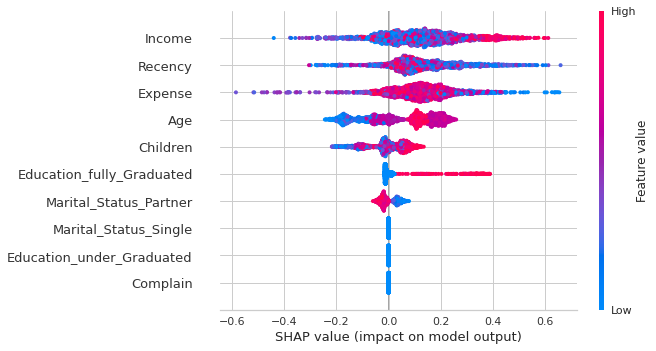

Shap values for AcceptedCmp1 


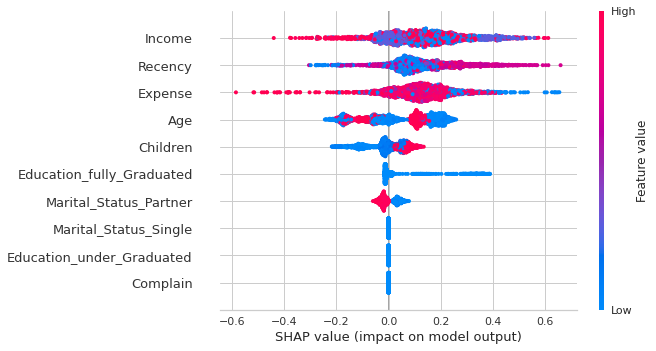

Shap values for AcceptedCmp2 


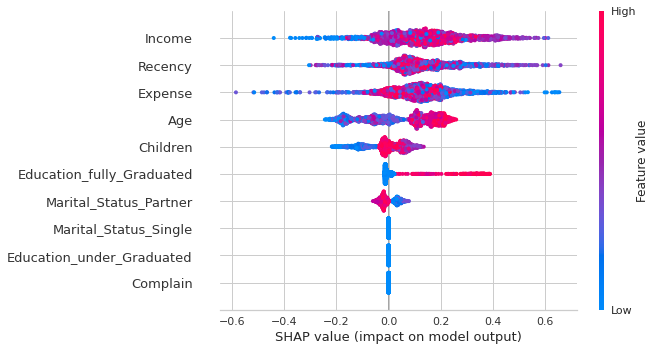

Shap values for AcceptedCmp3 


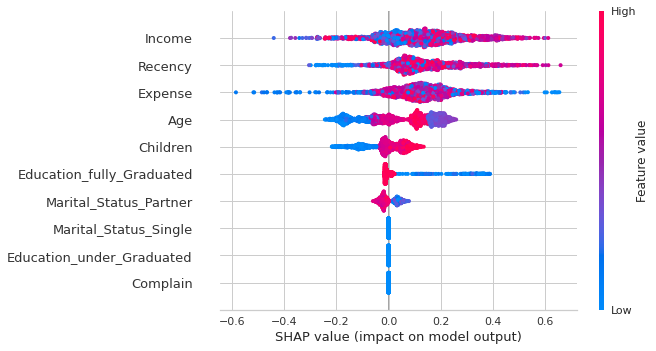

Shap values for AcceptedCmp4 


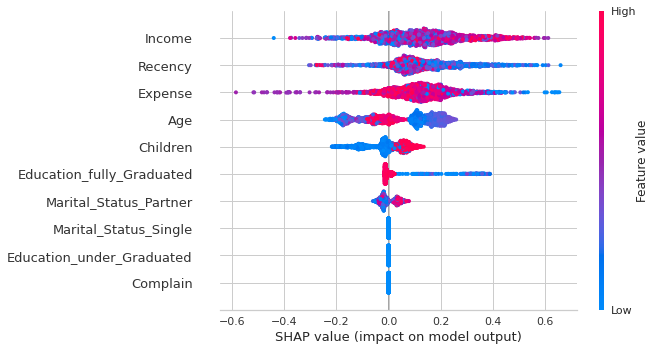

Shap values for AcceptedCmp5 


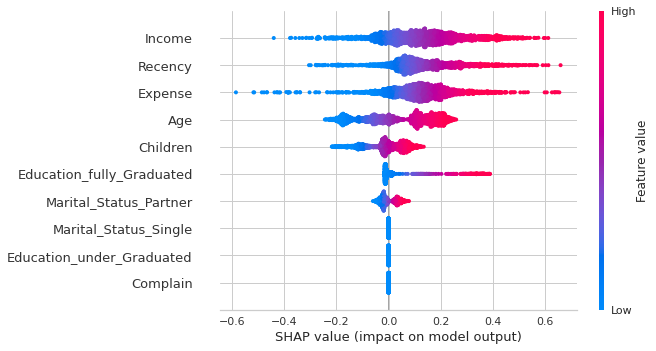

In [42]:
for i in range (0, len(shap_values_lis)):
    print("Shap values for AcceptedCmp{} ".format(i))
    shap.summary_plot(shap_values,shap_values_lis[i], feature_names=xi.columns)

We can see that with the SHAP values for each label with respect to the features modelled:
1. Education, Complain, Marital_status_Single have low impact on the model.
2. Income, Recency and Expense have huge positive impact on Model.